In [1]:
import pandas as pd, tensorflow as tf, os, numpy as np, matplotlib.pyplot as plt
from zipfile import ZipFile

In [15]:


# uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
# zip_path = tf.keras.utils.get_file(origin=uri_, fname="jena_climate_2009_2016.csv.zip")
# zip_file = ZipFile(zip_path)
# zip_file.extractall()
csv_path = "C:\\Users\\jix\\Desktop\\PROJECTS\\time-series\\jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
df_hourly = df[::6]

In [5]:
df_hourly.index = pd.to_datetime(df_hourly['Date Time'], format=r'%d.%m.%Y %H:%M:%S')
# df_hourly.index = np.arange(0, len(df_hourly))



In [6]:

del df_hourly['Date Time'] 


In [7]:
df_hourly.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
2009-01-01 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
2009-01-01 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
2009-01-01 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


<Axes: xlabel='Date Time'>

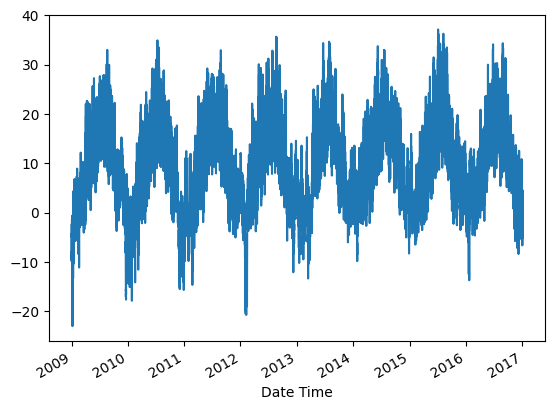

In [8]:
tempC = df_hourly['T (degC)']
tempC.plot()

In [9]:
def df_to_X_y(df_hourly, window_size=5):
    df_hourly_np = df_hourly.to_numpy()
    X = []
    y = []
    for i in range(len(df_hourly_np) - window_size):
        row = [[a] for a in df_hourly_np[i:i+5]]
        X.append(row)
        label = df_hourly_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [10]:
WINDOW_SIZE = 5
X, y = df_to_X_y(tempC, WINDOW_SIZE)
X.shape, y.shape

((70087, 5, 1), (70087,))

In [11]:
X_train, y_train = X[:6000], y[:6000]
X_val, y_val = X[6000:6500], y[6000:6500]
X_test, y_test = X[6500:], y[6500:]


In [111]:
X_train.shape

(6000, 5, 1)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# defininig model
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)
with tf.device('/CPU:0'):
    model_1 = Sequential()
    model_1.add(InputLayer(shape=(5, 1)))
    model_1.add(LSTM(64))
    model_1.add(Dense(8))
    model_1.add(LeakyReLU(0.2))
    model_1.add(Dense(1, 'linear'))

# dsiplay architecture
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
checkpoint = ModelCheckpoint('model_1.keras', save_best_only=True)

model_1.compile(optimizer='adam',
              loss='mse',
              metrics=[RootMeanSquaredError()])

# model_1.compile(optimizer=Adam(learning_rate=0.0001),
#               loss=MeanSquaredError(),
#               metrics=[RootMeanSquaredError()])

In [14]:
# model_1.fit(X_train, y_train,
#             validation_data=(X_val, y_val),
#             epochs=10, callbacks=checkpoint)

In [15]:
from tensorflow.keras.models import load_model
model_1 = load_model('model_1.keras')


In [16]:
res_1 = np.round_(model_1.predict(tf.expand_dims(X_test[0], axis=0)), 2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


In [17]:
res_1, y_test[0]

(array([[13.23]], dtype=float32), 13.26)

In [18]:
result_1_X_test = np.round_(model_1.predict(X_test), 2)

1988/1988 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step


In [19]:
result_1_X_test.flatten()[0], y_test[0]


(13.23, 13.26)

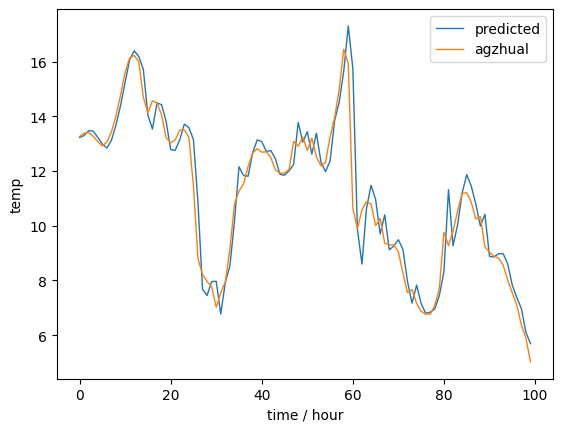

In [20]:
test_res = pd.DataFrame(data={'test results':result_1_X_test.flatten(), 'real test':y_test})

plt.xlabel("time / hour") 
plt.ylabel("temp") 
plt.plot(test_res['test results'][:100], linewidth=1, label="predicted")
plt.plot(test_res['real test'][:100], linewidth=1, label="agzhual")
plt.legend(loc='upper right', ncol=1) 


In [21]:
# from zipfile import ZipFile 
  
# # loading the temp.zip and creating a zip object 
# with ZipFile("C:\\Users\\jix\Desktop\\PROJECTS\\time-series\\time_series_model.zip", 'r') as z: 
  
#     # Extracting all the members of the zip  
#     # into a specific location. 
#     z.extractall( 
#         path=r"C:\\Users\\jix\\Desktop\\PROJECTS\\time-series\\loaded_model")

In [22]:
type(y_test)

numpy.ndarray

In [23]:
from typing import Optional

def plot_refrences(model_path:str, input_data:np.array, real_results:np.array,
                   start:int | None  = None, end:int | None = None):
    model = load_model(model_path)
    pred_results = np.array(model.predict(input_data)).flatten()

    test_res = pd.DataFrame(data={'test results':np.round_(pred_results, 2),
                                   'real test':real_results})
    plt.xlabel("time / hour") 
    plt.ylabel("temp")
    plt.plot(test_res['test results'][start:end], linewidth=1, label="predicted")
    plt.plot(test_res['real test'][start:end], linewidth=1, label="agzhual")
    plt.legend(loc='upper right', ncol=1) 
    

In [24]:
print(os.getcwd())

c:\Users\jix\Desktop\PROJECTS\time-series


1988/1988 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step


C:\Users\jix\AppData\Local\Temp\ipykernel_12368\1684599805.py:1: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  plot_refrences('model_1.keras', X_test, y_test, 0, 100)


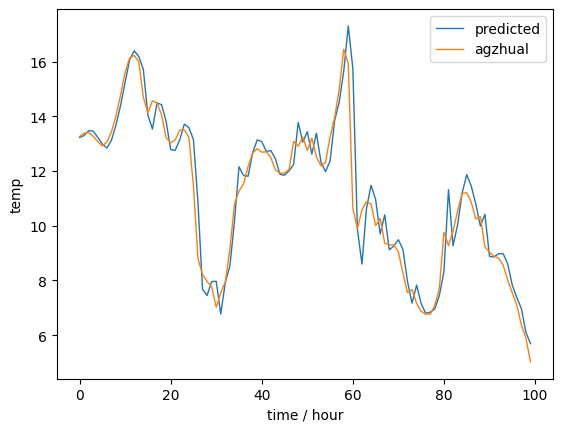

In [25]:
plot_refrences('model_1.keras', X_test, y_test, 0, 100)

In [26]:
import sklearn
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.layers import InputLayer, LSTM, Dense, LeakyReLU, Conv1D, Flatten, GRU
from tensorflow import keras
# defininig model
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)
with tf.device('/CPU:0'):
    model_2 = Sequential()
    model_2.add(InputLayer(shape=(5, 1)))
    # replaced LSTM with Conv1D
    model_2.add(Conv1D(64, kernel_size=2))
    model_2.add(Flatten())
    # model_2.add(LSTM(64))
    model_2.add(Dense(8, activation="gelu"))
    # model_2.add(LeakyReLU(0.2))
    model_2.add(Dense(1, 'linear'))

# dsiplay architecture
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
checkpoint = ModelCheckpoint('model_2.keras', save_best_only=True)
model_2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',
              metrics=[RootMeanSquaredError()])

In [28]:
model_2.fit(X_train, y_train, epochs=15,shuffle=True, validation_data=(X_val,y_val),
            callbacks=[checkpoint])

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 102.9135 - root_mean_squared_error: 10.0315 - val_loss: 13.9202 - val_root_mean_squared_error: 3.7310
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 10.3096 - root_mean_squared_error: 3.2035 - val_loss: 7.7656 - val_root_mean_squared_error: 2.7867
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 6.9111 - root_mean_squared_error: 2.6280 - val_loss: 7.3030 - val_root_mean_squared_error: 2.7024
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 6.1166 - root_mean_squared_error: 2.4725 - val_loss: 6.7706 - val_root_mean_squared_error: 2.6020
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 5.3906 - root_mean_squared_error: 2.3211 - val_loss: 6.1797 - val_root_mean_squared_error: 2.4859
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 5.1028 - root_mean_squared_error: 2.2577 - val_loss: 5.5819 - val_root_mean_squared_error: 2.3626
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━

In [29]:

X_test_0 = tf.expand_dims(X_test[0], axis=0)


In [30]:

res_2 = np.round_(model_2.predict(X_test_0), 2)
res_2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[13.07]], dtype=float32)

In [31]:
res_1, res_2

(array([[13.23]], dtype=float32), array([[13.07]], dtype=float32))

In [32]:
res_1, res_2, y_test[0]
np.abs(res_1 - y_test[0]), np.abs(res_2 - y_test[0])

(array([[0.03000069]], dtype=float32), array([[0.19000053]], dtype=float32))

1988/1988 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step
 292/1988 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step

C:\Users\jix\AppData\Local\Temp\ipykernel_12368\3041334196.py:2: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  plt.subplot(121);plot_refrences('model_1.keras', X_test, y_test, 0, 100)


1988/1988 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step


C:\Users\jix\AppData\Local\Temp\ipykernel_12368\3041334196.py:3: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  plt.subplot(122);plot_refrences('model_2.keras', X_test, y_test, 0, 100)


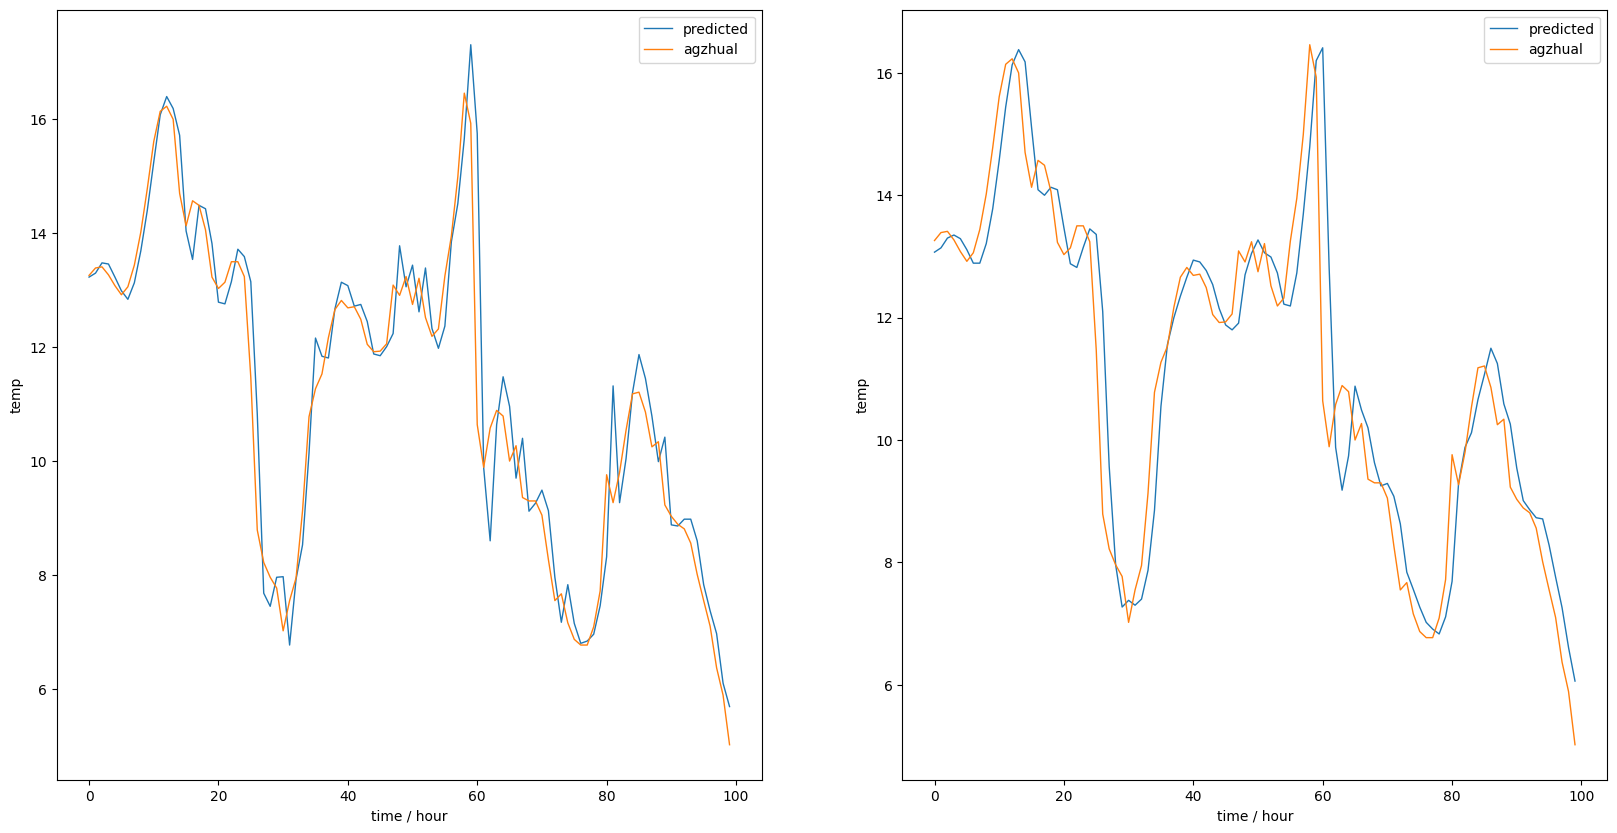

In [33]:
plt.figure(figsize=(20, 10))
plt.subplot(121);plot_refrences('model_1.keras', X_test, y_test, 0, 100)
plt.subplot(122);plot_refrences('model_2.keras', X_test, y_test, 0, 100)


In [34]:
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)
with tf.device('/CPU:0'):
    model_3 = Sequential()
    model_3.add(InputLayer(shape=(5, 1)))
    # replaced LSTM with Conv1D
    # model_2.add(Conv1D(64, kernel_size=2))
    # model_2.add(Flatten())
    model_3.add(GRU(64))
    model_3.add(Dense(8, activation="gelu"))
    # model_2.add(LeakyReLU(0.2))
    model_3.add(Dense(1, 'linear'))

# dsiplay architecture
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,393 (52.32 KB)

 Trainable params: 13,393 (52.32 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
checkpoint = ModelCheckpoint('model_3.keras', save_best_only=True)
model_3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',
              metrics=[RootMeanSquaredError()])

model_3.fit(X_train, y_train, epochs=12,shuffle=True, validation_data=(X_val,y_val),
            callbacks=[checkpoint])

Epoch 1/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 177.6298 - root_mean_squared_error: 13.3211 - val_loss: 127.6514 - val_root_mean_squared_error: 11.2983
Epoch 2/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94.5647 - root_mean_squared_error: 9.7053 - val_loss: 47.9295 - val_root_mean_squared_error: 6.9231
Epoch 3/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.4308 - root_mean_squared_error: 6.8097 - val_loss: 22.4364 - val_root_mean_squared_error: 4.7367
Epoch 4/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.7768 - root_mean_squared_error: 5.0733 - val_loss: 11.0322 - val_root_mean_squared_error: 3.3215
Epoch 5/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2978 - root_mean_squared_error: 4.0274 - val_loss: 6.5346 - val_root_mean_squared_error: 2.5563
Epoch 6/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.2015 - root_mean_squared_error: 3.1927 - val_loss: 4.3126 - val_root_mean_squared_error: 2.0767
Epoch 7/12
188/188 ━━━━━━━━━━━━━━━━━━━

In [36]:
res_3 = model_3.predict(X_test_0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [37]:
res_1[0][0], res_2[0][0], np.round_(res_3, 2)[0][0], y_test[0]

(13.23, 13.07, 13.32, 13.26)

In [38]:
tempC.head()
# tempC.index[:5]
tempC_df = pd.DataFrame({'temperature':tempC})

In [39]:
tempC_df.index[0] == tempC.index[0]
# tempC[0].index

True

In [40]:
tempC_df['Seconds'] = tempC.index.map(pd.Timestamp.timestamp)
tempC_df.head()

,temperature,Seconds
Date Time,,
2009-01-01 00:10:00,-8.02,1.230769e+09
2009-01-01 01:10:00,-7.62,1.230772e+09
2009-01-01 02:10:00,-8.85,1.230776e+09
2009-01-01 03:10:00,-8.84,1.230779e+09
2009-01-01 04:10:00,-9.23,1.230783e+09


In [41]:
24 * 3600

86400

In [13]:
seconds = tempC.index.map(pd.Timestamp.timestamp)

ValueError: from_unit must be <= to_unit

In [43]:
day = 86400
Year = 365.2425 * day
tempC_df['Day sin'] = 1
tempC_df['Day sin'] = np.sin(seconds * (2 * np.pi / day))
tempC_df['Day cos'] = np.cos(seconds * (2 * np.pi / day))
tempC_df['Year sin'] = np.sin(seconds * (2 * np.pi / Year))
tempC_df['Year cos'] = np.cos(seconds * (2 * np.pi / Year))

In [50]:
# tempC_df = tempC_df.drop(['Seconds'], axis=1)
tempC_df.head()
# df.drop(['A'], axis=1)

,temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 00:10:00,-8.02,0.043619,0.999048,0.009452,0.999955
2009-01-01 01:10:00,-7.62,0.300706,0.953717,0.010169,0.999948
2009-01-01 02:10:00,-8.85,0.537300,0.843391,0.010885,0.999941
2009-01-01 03:10:00,-8.84,0.737277,0.675590,0.011602,0.999933
2009-01-01 04:10:00,-9.23,0.887011,0.461749,0.012319,0.999924


In [68]:

# tempC_df = tempC_df.drop(['Days'], axis=1)
# tempC_df.to_numpy()[:10]
tempC_df.head(11)

,temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 00:10:00,-8.02,0.043619,0.999048,0.009452,0.999955
2009-01-01 01:10:00,-7.62,0.300706,0.953717,0.010169,0.999948
2009-01-01 02:10:00,-8.85,0.537300,0.843391,0.010885,0.999941
2009-01-01 03:10:00,-8.84,0.737277,0.675590,0.011602,0.999933
2009-01-01 04:10:00,-9.23,0.887011,0.461749,0.012319,0.999924
2009-01-01 05:10:00,-9.67,0.976296,0.216440,0.013036,0.999915
2009-01-01 06:10:00,-9.59,0.999048,-0.043619,0.013752,0.999905
2009-01-01 07:10:00,-8.71,0.953717,-0.300706,0.014469,0.999895
2009-01-01 08:10:00,-8.14,0.843391,-0.537300,0.015186,0.999885


In [52]:
tempC_df_np = tempC_df.to_numpy()

np.round(tempC_df_np[0:0+5], 5), tempC_df_np[0:0+5]
len(tempC_df_np)


70092

In [143]:
def df_to_X_y_2(tempC_df_, window_size=6):
    tempC_df_np = np.round(tempC_df_.to_numpy(), 5)
    X = []
    y = []
    for i in range(len(tempC_df_np) - window_size):
        row = [[a] for a in tempC_df_np[i:i+window_size]]
        X.append(row)
        label = tempC_df_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [144]:
X_2, y_2 = df_to_X_y_2(tempC_df)

X_2 = [np.squeeze(x) for x in X_2]
X_2 = np.array(X_2)


In [145]:
int(len(X_2) * 0.75)
len_train = int(len(X_2) * 0.75)
len_val = int(len(X_2) * 0.1)
len_test = int(len(X_2) * 0.15)
len_train, len_val, len_test



(52564, 7008, 10512)

In [146]:
from sklearn.model_selection import train_test_split

X_2_train, y_2_train = X_2[:len_train], y_2[:len_train]
X_2_val, y_2_val = X_2[len_train:len_train + len_val], y_2[len_train:len_train + len_val]
X_2_test, y_2_test = X_2[len_train + len_val:], y_2[len_train + len_val:]




In [139]:
X_2_train.shape, X_2_val.shape, X_2_test.shape

((52564, 6, 5), (7008, 6, 5), (10514, 6, 5))

In [149]:
def preprocess(X):
    temp_X_2_train_mean = np.mean(X[:, :, 0])
    temp_X_2_train_std = np.std(X[:, :, 0])
    X[:, :, 0] = (X[:, :, 0] - temp_X_2_train_mean) / temp_X_2_train_std
    return X


In [153]:
preprocess(X_2_train)
preprocess(X_2_test)
preprocess(X_2_val)
'ss'

'ss'

In [172]:
import sklearn
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.layers import InputLayer, LSTM, Dense, LeakyReLU, Conv1D, Flatten, GRU
from tensorflow import keras
# defininig model
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)
with tf.device('/CPU:0'):
    model_4 = Sequential()
    model_4.add(InputLayer(shape=(6, 5)))
    # replaced LSTM with Conv1D
    model_4.add(Conv1D(64, kernel_size=2))
    model_4.add(Flatten())
    # model_2.add(LSTM(64))
    model_4.add(Dense(8, activation="gelu"))
    # model_2.add(LeakyReLU(0.2))
    model_4.add(Dense(1, 'linear'))

# dsiplay architecture
model_4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 5, 64)          │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │         2,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

In [176]:
checkpoint_4 = ModelCheckpoint('model_4.keras', save_best_only=True)

# model_1.compile(optimizer='adam',
#               loss='mse',
#               metrics=[RootMeanSquaredError()])

model_4.compile(optimizer=Adam(learning_rate=0.0001),
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])

In [177]:
model_4.fit(X_2_train, y_2_train,
            validation_data=(X_2_val, y_2_val),
            epochs=20, callbacks=checkpoint_4)
# try shuffle

Epoch 1/20
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 2s 624us/step - loss: 112.9569 - root_mean_squared_error: 10.5474 - val_loss: 20.3078 - val_root_mean_squared_error: 4.5064
Epoch 2/20
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - loss: 12.3232 - root_mean_squared_error: 3.5052 - val_loss: 9.5139 - val_root_mean_squared_error: 3.0845
Epoch 3/20
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - loss: 3.6729 - root_mean_squared_error: 1.9127 - val_loss: 6.9646 - val_root_mean_squared_error: 2.6391
Epoch 4/20
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 2.3658 - root_mean_squared_error: 1.5368 - val_loss: 5.7760 - val_root_mean_squared_error: 2.4033
Epoch 5/20
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step - loss: 1.2135 - root_mean_squared_error: 1.1008 - val_loss: 4.9058 - val_root_mean_squared_error: 2.2149
Epoch 6/20
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - loss: 0.8959 - root_mean_squared_error: 0.9463 - val_loss: 5.1162 - val_root_mean_squared_error: 2.2619
Epoch 7/20
1643/1643 ━━

In [178]:
res_4 = model_4.predict(X_2_test)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


In [179]:
res_4[2000], y_2_test[2000]

(array([-4.3995624], dtype=float32), -2.39)

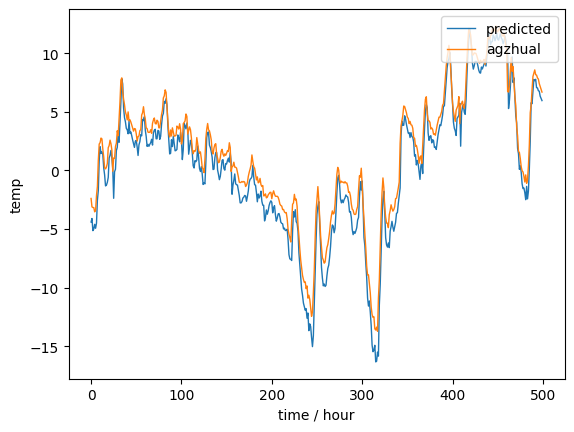

In [185]:
plt.xlabel("time / hour") 
plt.ylabel("temp") 
plt.plot(res_4[2000:2500], linewidth=1, label="predicted")
plt.plot(y_2_test[2000:2500], linewidth=1, label="agzhual")
plt.legend(loc='upper right', ncol=1)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


C:\Users\jix\AppData\Local\Temp\ipykernel_12368\3480918205.py:1: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  plot_refrences('model_4.keras', X_2_test, y_2_test, 0, 500)


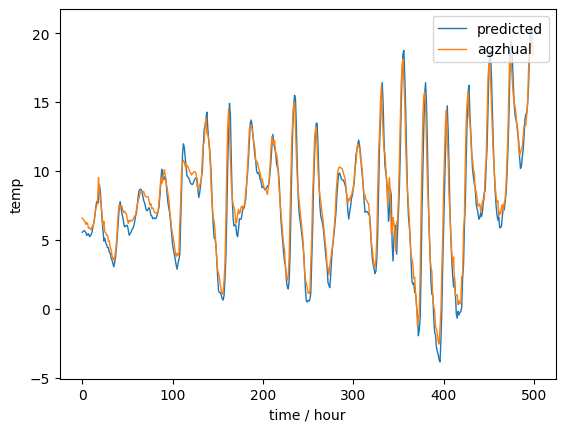

In [187]:
plot_refrences('model_4.keras', X_2_test, y_2_test, 0, 500)

In [73]:
import pandas as pd, tensorflow as tf, os, numpy as np, matplotlib.pyplot as plt
from zipfile import ZipFile

In [74]:
csv_path = "C:\\Users\\jix\\Desktop\\PROJECTS\\time-series\\jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)
df_hourly = df[::6]
df_hourly.index = pd.to_datetime(df_hourly['Date Time'], format=r'%d.%m.%Y %H:%M:%S')
tempC = df_hourly['T (degC)']
tempC_df = pd.DataFrame({'temperature':tempC})
seconds = tempC.index.map(pd.Timestamp.timestamp)
day = 86400
Year = 365.2425 * day
tempC_df['Day sin'] = 1
tempC_df['Day sin'] = np.sin(seconds * (2 * np.pi / day))
tempC_df['Day cos'] = np.cos(seconds * (2 * np.pi / day))
tempC_df['Year sin'] = np.sin(seconds * (2 * np.pi / Year))
tempC_df['Year cos'] = np.cos(seconds * (2 * np.pi / Year))

In [75]:
P_T_df = pd.concat([df_hourly['p (mbar)'], tempC_df], axis=1)
P_T_df.head()

,p (mbar),temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 00:10:00,996.52,-8.02,0.043619,0.999048,0.009452,0.999955
2009-01-01 01:10:00,996.50,-7.62,0.300706,0.953717,0.010169,0.999948
2009-01-01 02:10:00,996.63,-8.85,0.537300,0.843391,0.010885,0.999941
2009-01-01 03:10:00,996.87,-8.84,0.737277,0.675590,0.011602,0.999933
2009-01-01 04:10:00,997.05,-9.23,0.887011,0.461749,0.012319,0.999924


In [76]:
def df_to_X_y_3(df_hourly, window_size=7):
    df_hourly_np = df_hourly.to_numpy()
    X = []
    y = []
    for i in range(len(df_hourly_np) - window_size):
        row = [[a] for a in df_hourly_np[i:i+window_size]]
        X.append(row)
        label = df_hourly_np[i+window_size][0], df_hourly_np[i+window_size][1]
        y.append(label)
    return np.array(X), np.array(y)

In [77]:
X_3, y_3 = df_to_X_y_3(P_T_df)


array([ 1.19806958, -2.09812755])

In [78]:
X_3 = X_3.reshape(70085, 7, 6) # X_3.squeeze() also works
X_3.shape, y_3.shape

len_train = int(len(X_3) * 0.75)
len_val = int(len(X_3) * 0.1)
len_test = int(len(X_3) * 0.15)
len_train, len_val, len_test
X_3_train, y_3_train = X_3[:len_train], y_3[:len_train]
X_3_val, y_3_val = X_3[len_train:len_train + len_val], y_3[len_train:len_train + len_val]
X_3_test, y_3_test = X_3[len_train + len_val:], y_3[len_train + len_val:]

In [80]:
X_3_train[0:5, 0, :2]
# X_3_train.shape

array([[996.52,  -8.02],
       [996.5 ,  -7.62],
       [996.63,  -8.85],
       [996.87,  -8.84],
       [997.05,  -9.23]])

In [81]:
X_3_train[:3, :, 1], X_3_train[:3, :, 0]
np.mean(X_3_train[:, :, 1]), np.mean(X_3_train[:, :, 0])
np.std(X_3_train[:, :, 1]), np.std(X_3_train[:, :, 0])

(8.535424056531584, 8.175271639720501)

In [82]:

temp_y_train_mean = np.mean(y_3_test[:, 1])
temp_y_train_std = np.std(y_3_test[:, 1])
p_y_train_mean = np.mean(y_3_test[:, 0])
p_y_train_std = np.std(y_3_test[:, 0])

y_3_test[0]

array([992.34,   6.58])

In [83]:
def preprocess_T_P(X, y):
    temp_X_train_mean = np.mean(X[:, :, 1])
    temp_X_train_std = np.std(X[:, :, 1])
    p_X_train_mean = np.mean(X[:, :, 0])
    p_X_train_std = np.std(X[:, :, 0])
    X[:, :, 1] = (X[:, :, 1] - temp_X_train_mean) / temp_X_train_std
    X[:, :, 0] = (X[:, :, 0] - p_X_train_mean) / p_X_train_std
    temp_y_train_mean = np.mean(y[:, 1])
    temp_y_train_std = np.std(y[:, 1])
    p_y_train_mean = np.mean(y[:, 0])
    p_y_train_std = np.std(y[:, 0])
    y[:, 1] = (y[:, 1] - temp_y_train_mean) / temp_y_train_std
    y[:, 0] = (y[:, 0] - p_y_train_mean) / p_y_train_std
    return X, y
# 
# def preprocess_T_P_y(y):
#     temp_X_train_mean = np.mean(y[:, :, 1])
#     temp_X_train_std = np.std(y[:, :, 1])
#     p_X_train_mean = np.mean(y[:, :, 0])
#     p_X_train_std = np.std(y[:, :, 0])
#     y[:, :, 1] = (y[:, :, 1] - temp_X_train_mean) / temp_X_train_std
#     y[:, :, 0] = (y[:, :, 0] - p_X_train_mean) / p_X_train_std
#     return y

In [84]:
preprocess_T_P(X_3_train, y_3_train)
preprocess_T_P(X_3_val, y_3_val)
preprocess_T_P(X_3_test, y_3_test)
'ss'

'ss'

In [85]:
import sklearn
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, LeakyReLU, Conv1D, Flatten, GRU
from tensorflow import keras
# defininig model
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)
with tf.device('/CPU:0'):
    model_4 = Sequential()
    model_4.add(InputLayer(shape=(7, 6)))
    # replaced LSTM with Conv1D
    model_4.add(Conv1D(64, kernel_size=2))
    model_4.add(Flatten())
    # model_2.add(LSTM(64))
    model_4.add(Dense(8,
                    #    activation="gelu")
                       ))
    model_4.add(LeakyReLU(0.2))
    model_4.add(Dense(2, 'linear'))

# dsiplay architecture
model_4.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 6, 64)          │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         3,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,930 (15.35 KB)

 Trainable params: 3,930 (15.35 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
checkpoint = ModelCheckpoint('model_5.keras', save_best_only=True)
model_4.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',
              metrics=[RootMeanSquaredError()])

model_4.fit(X_3_train, y_3_train, epochs=12,shuffle=True, validation_data=(X_3_val,y_3_val),
            callbacks=[checkpoint])

Epoch 1/12
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - loss: 0.1901 - root_mean_squared_error: 0.4081 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1438
Epoch 2/12
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - loss: 0.0158 - root_mean_squared_error: 0.1254 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032
Epoch 3/12
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - loss: 0.0091 - root_mean_squared_error: 0.0953 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 4/12
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - loss: 0.0087 - root_mean_squared_error: 0.0930 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848
Epoch 5/12
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 6/12
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 7/12
1643/1643 ━━━━━━━

In [87]:
tf.expand_dims(X_3_test[0], axis=0).shape, X_3_test[0].shape, X_3_train[0].shape

(TensorShape([1, 7, 6]), (7, 6), (7, 6))

In [88]:
res_5 = model_4.predict(X_3_test)
type(model_4)

res_5[:, 0].shape, y_3_test[:, 0].shape

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


((10514,), (10514,))

In [89]:
from typing import Optional

def plot_refrences(model:Sequential,
                   input_data:np.array, real_results:np.array,
                   start:Optional[int], end:int | None = None):
    # model = load_model(model_path)

    pred_results = np.array(model.predict(input_data)) # .flatten()

    test_res = pd.DataFrame(data={'test pressure results':np.round_(pred_results[:,0], 5),
                                   'real pressure test':real_results[:, 0],
                                   'temp results':np.round_(pred_results[:,1], 5),
                                   'real temp test': real_results[:, 1]})
    plt.figure(figsize=(20, 10))
    plt.xlabel("time / hour") 
    plt.ylabel("pressure")
    plt.subplot(121);plt.plot(test_res['test pressure results'][start:end], linewidth=1, label="predicted")
    plt.subplot(121);plt.plot(test_res['real pressure test'][start:end], linewidth=1, label="agzhual")
    plt.subplot(122);plt.plot(test_res['temp results'][start:end], linewidth=1, label="predicted");plt.ylabel("temperature")
    plt.subplot(122);plt.plot(test_res['real temp test'][start:end], linewidth=1, label="agzhual")
    plt.legend(loc='upper right', ncol=1) 
    

In [90]:
res_5.shape, y_3_test.shape

((10514, 2), (10514, 2))

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


C:\Users\jix\AppData\Local\Temp\ipykernel_3516\213052250.py:1: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  plot_refrences(model_4, X_3_test, y_3_test, 0, 500)


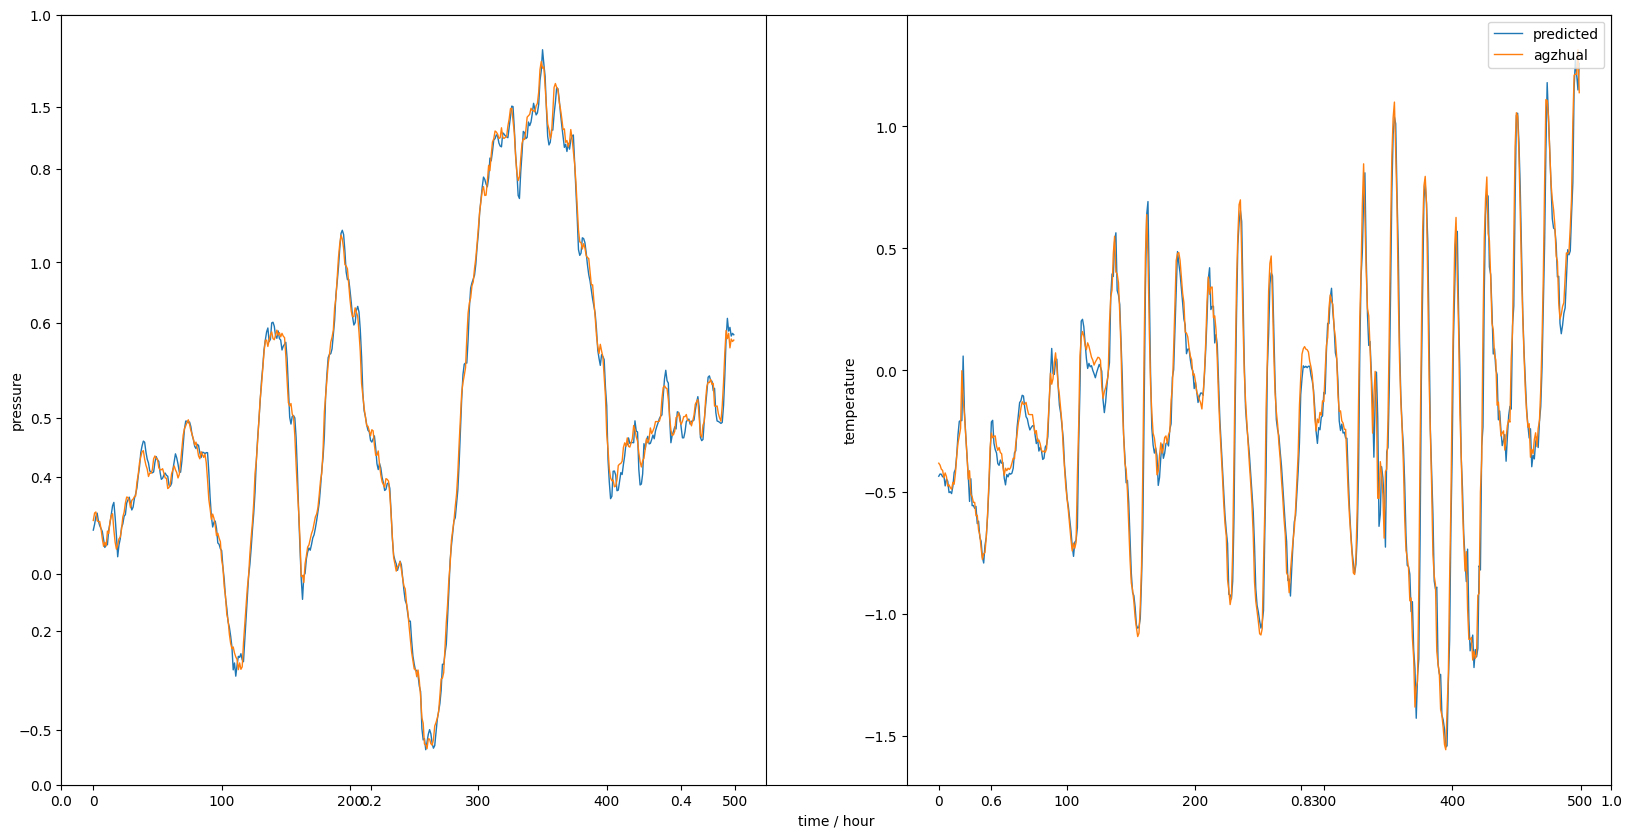

In [91]:
plot_refrences(model_4, X_3_test, y_3_test, 0, 500)

In [92]:
res_5.shape, y_3_test.shape


((10514, 2), (10514, 2))

In [93]:
temp_y_train_mean, temp_y_train_std, p_y_train_mean, p_y_train_std




(9.545535476507515, 7.779086466305873, 990.8319783146281, 8.788441208914291)

In [94]:
y_pred = res_5[0, 0] * p_y_train_std + p_y_train_mean
y_test = y_3_test[0, 0] * p_y_train_std + p_y_train_mean
y_pred, y_test

(992.0677109011824, 992.34)

In [101]:
for item in res_5[:, 0]:
    item = item * p_y_train_std + p_y_train_mean

item_5_p = [item * p_y_train_std + p_y_train_mean for item in res_5[:, 0]]
item_5_t = [item * temp_y_train_std + temp_y_train_mean for item in res_5[:, 1]]
item_5_p_real = [item * p_y_train_std + p_y_train_mean for item in y_3_test[:, 0]]
item_5_t_real = [item * temp_y_train_std + temp_y_train_mean for item in y_3_test[:, 1]]
# item_5_p_real[0], item_5_t_real[0]

(992.34, 6.58)

In [104]:
item_5_p_real[1000], item_5_p[1000]

(983.1, 982.9721732312863)

In [ ]:


# git remote add origin 'https://github.com/jixaw31/time-series.git'

# git init
# git status
# git add .
# git remote add origin 'https://github.com/jixaw31/time-series.git'

# git pull origin "main"
# git push g
# git commit -m "initial commit"
# git push origin main